<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/pretrained_word_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glove Word Embeddings

## Import

In [79]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM,\
                         TextVectorization, MaxPooling1D, Dropout

## Dataset

In [80]:
# Dataset - 2880 movie reviews from IMDB (raw string)
# 1440 negatives and 1440 positives reviews

imdb_dir = '/content/drive/MyDrive/imdb-dataset/'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      f = open(os.path.join(dir_name, fname))
      texts.append(f.read())
      f.close()
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

print("Example from dataset : ", texts[0])
print("Sentiment : ", "Negative" if labels[0] == 0 else "Positive")

Example from dataset :  Perhaps I'm being too generous when I give this film two and a half stars out of five, but there was an occasional moment. However, as "An American Werewolf" movie this one is a missed chance! There are no real plot connections to the superior original to speak of, but the story is similar in some ways to "London".<br /><br />*Possible Spoiler Warning* American kids go to foreign country, one falls in love with a beautiful girl. Another one of the kids gets slaughtered by a werewolf in the same night that one gets bitten, and despite his undead friend's warnings, by the light of the full moon he sprouts fur, fangs, and claws!<br /><br />But there are some differences in the story, for one; the girl is one of the werewolves. Second; there are three American Kids. And third; there's some weird-@$$ werewolf cult intent on taking over the world! As crazy as it sounds, that last one, WASN'T a joke! *Spoiler Ends*<br /><br />The films suffers from many things, first t

## Preprocessing

In [81]:
import re

def regularize(text):
  text =  re.sub('[^a-zA-Z0-9 \n\.]', '', text) # remove special chars
  
  return text

regularized_texts = [regularize(text) for text in texts]


In [82]:
# Preprocessing - sentences to sequences

maxlen = 200
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(regularized_texts)
sequences = tokenizer.texts_to_sequences(regularized_texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen, padding="post")
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 32215 unique tokens.
Shape of data tensor: (2880, 200)
Shape of label tensor: (2880,)


In [83]:
# Splitting for test set

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

x_set = data[indices]
y_set = labels[indices]

test_sep = int(len(x_set) * 0.2)

x_train = x_set[test_sep:]
y_train = y_set[test_sep:]

x_test = x_set[:test_sep]
y_test = y_set[:test_sep]

print("Found {} elements for train set".format(len(x_train)))
print("Found {} elements for test set".format(len(x_test)))


Found 2304 elements for train set
Found 576 elements for test set


## Glove

In [84]:
# Parsing Glove file - 400 000 word vectors of 100 dims

glove_dir = '/content/drive/MyDrive/glove/'
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs

f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [85]:
# Preparing Glove word embeddings matrix

embedding_dim = 100
hit = 0
misses = []
embedding_matrix = np.zeros((max_words, embedding_dim))

print(max_words)

for word, i in word_index.items():
  
  if i == max_words:
    break
  
  embedding_vector = embeddings_index.get(word)

  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hit += 1
  else:
    misses.append(word)


print("Found Terms : {} | Not Found Terms : {}".format(hit, len(misses)))
print("Not found samples : ", misses[:20])

10000
Found Terms : 9747 | Not Found Terms : 252
Not found samples :  ['youve', 'clichs', 'lowbudget', 'bmovie', 'werent', 'shouldnt', 'hitchcocks', 'clichd', 'chanwook', 'brunos', 'overthetop', 'raisuli', 'couldve', 'fishmen', 'thebr', 'hadnt', 'writerdirector', 'sakall', 'wouldve', 'theyve']


In [86]:
from scipy.spatial.distance import cosine

# Example of similarity for two words

word1 = embeddings_index["hello"]
word2 = embeddings_index["hi"]

similarity = cosine(word1, word2)

print("Similarity : {}%".format(similarity * 100))

Similarity : 59.54926311969757%


## Model

In [87]:
# Model defintion - This model should predict the sentiment of a review

model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 100)          1000000   
                                                                 
 flatten_5 (Flatten)         (None, 20000)             0         
                                                                 
 dense_15 (Dense)            (None, 32)                640032    
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,640,065
Trainable params: 1,640,065
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Freeze model and set embedding matrix

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

## Training

In [89]:
# Training

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
58/58 [==============================] - 2s 16ms/step - loss: 1.0307 - acc: 0.4981 - val_loss: 0.6891 - val_acc: 0.5401
Epoch 2/10
58/58 [==============================] - 1s 13ms/step - loss: 0.7797 - acc: 0.6001 - val_loss: 0.6286 - val_acc: 0.6399
Epoch 3/10
58/58 [==============================] - 1s 12ms/step - loss: 0.5709 - acc: 0.7271 - val_loss: 0.6500 - val_acc: 0.6356
Epoch 4/10
58/58 [==============================] - 1s 13ms/step - loss: 0.3960 - acc: 0.8275 - val_loss: 1.0811 - val_acc: 0.5293
Epoch 5/10
58/58 [==============================] - 1s 13ms/step - loss: 0.2887 - acc: 0.8828 - val_loss: 0.6611 - val_acc: 0.6573
Epoch 6/10
58/58 [==============================] - 1s 17ms/step - loss: 0.2022 - acc: 0.9230 - val_loss: 0.7380 - val_acc: 0.6399
Epoch 7/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1174 - acc: 0.9691 - val_loss: 1.0905 - val_acc: 0.5987
Epoch 8/10
58/58 [==============================] - 1s 23ms/step - loss: 0.1008 - a

## Results

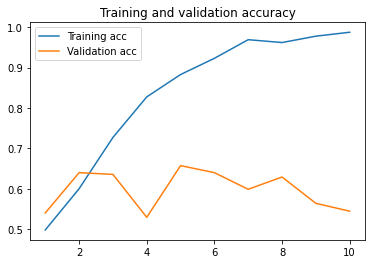

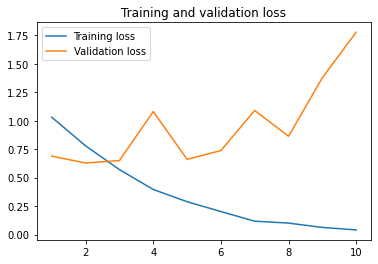

In [90]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [91]:
# Evaluate

loss, acc  = model.evaluate(x_test, y_test)
print("Accuracy : {}%".format(acc*100))

18/18 [==============================] - 0s 5ms/step - loss: 1.7977 - acc: 0.5365
Accuracy : 53.64583134651184%
